In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

arima_model_hi.pkl        df_stationary_final.csv       predicted_data_future.csv
arima_model.pkl           df_tmp_final.csv              predicted_data_past.csv
arima_model_rh.pkl        heat_index.csv                predicted_hi_data_future.csv
colombo_rh_2012-2018.csv  hi_arima_model_rh.pkl         predicted_hi_data_past.csv
colombo_t_2012-2018.csv   hi_predicted_data_future.csv
df_rh_final.csv           hi_predicted_data_past.csv


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%cd /content/drive/MyDrive/iotbda

/content/drive/MyDrive/iotbda


In [ ]:
%ls

arima_model_hi.pkl        df_stationary_final.csv       predicted_data_future.csv
arima_model.pkl           df_tmp_final.csv              predicted_data_past.csv
arima_model_rh.pkl        heat_index.csv                predicted_hi_data_future.csv
colombo_rh_2012-2018.csv  hi_arima_model_rh.pkl         predicted_hi_data_past.csv
colombo_t_2012-2018.csv   hi_predicted_data_future.csv
df_rh_final.csv           hi_predicted_data_past.csv


In [ ]:
# Step 1: Import necessary libraries and load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
from datetime import datetime



In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/iotbda/heat_index.csv',parse_dates=True)

print('Shape of dataset',data.shape)
data.head()

Shape of dataset (2557, 2)


,date,heat_index
0,2012-01-01,106.586916
1,2012-01-02,110.222986
2,2012-01-03,116.153191
3,2012-01-04,107.436420
4,2012-01-05,127.316863


**Remove duplicates and resample daily frequency**

In [ ]:

# Step 1: Remove duplicates
#data.drop_duplicates(subset='date', inplace=True)
data = data.loc[~data.index.duplicated(keep='first')]


In [ ]:
data['date'] = pd.to_datetime(data['date'])
# data.set_index('date', inplace=True)

In [ ]:
print(data.dtypes)

date          datetime64[ns]
heat_index           float64
dtype: object


In [ ]:
data

,date,heat_index
0,2012-01-01,106.586916
1,2012-01-02,110.222986
2,2012-01-03,116.153191
3,2012-01-04,107.436420
4,2012-01-05,127.316863
...,...,...
2552,2018-12-27,110.143555
2553,2018-12-28,101.184126
2554,2018-12-29,102.842606
2555,2018-12-30,107.629310


**Seasonality checking**

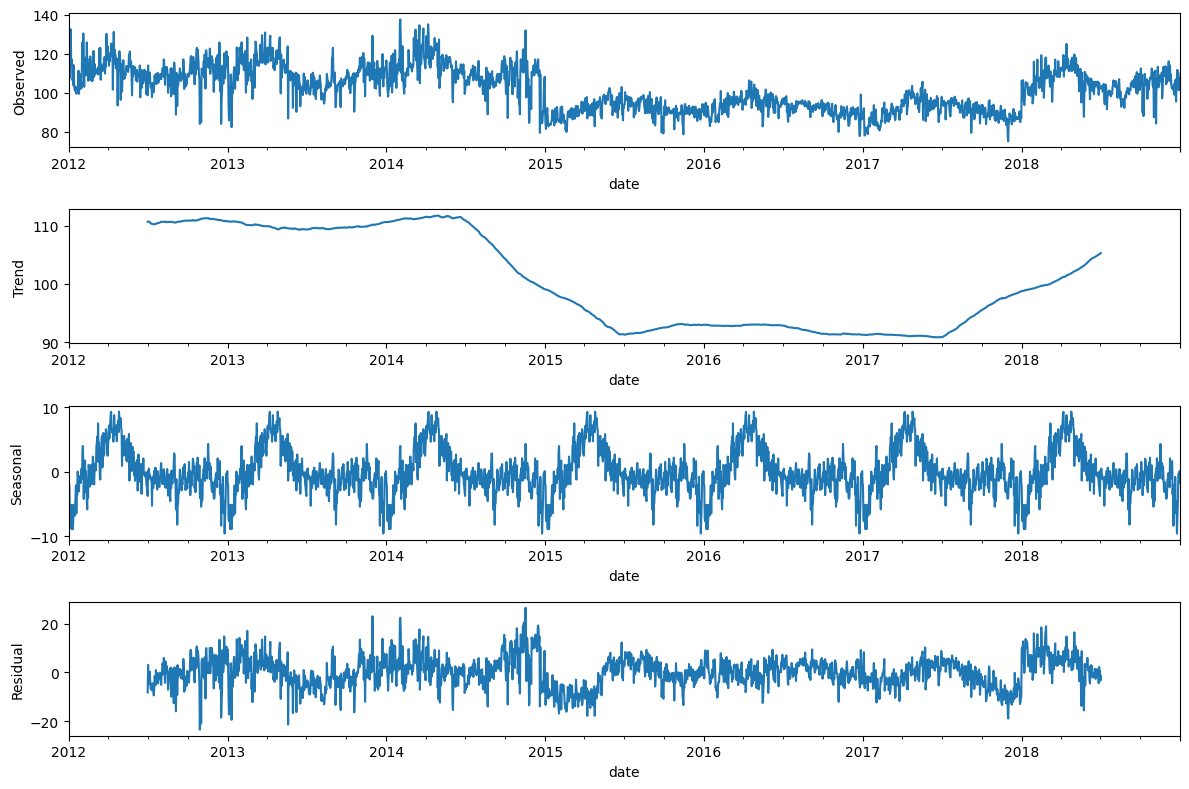

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert 'date' column to datetime format and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['heat_index'], model='additive', period=365)

# Plot the decomposed components
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')
decomposition.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax[3])
ax[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()


**ADF TEST FOR STATIONARITY**

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(data['heat_index'])

1. ADF :  -2.366455892316091
2. P-Value :  0.15142861888212145
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression: 2534
5. Critical Values :
	 1% :  -3.43293324257297
	 5% :  -2.8626812695784225
	 10% :  -2.5673775408540145


**p-value<0.05 so its stationary**

In [ ]:
data.to_csv("df_stationary_final.csv")

**Train and test split**

In [ ]:

# Split the data into train and test sets
train_percentage = 0.8  # Use 80% of the data for training
train_size = int(len(data) * train_percentage)
train_data = data[:train_size]
test_data = data[train_size:]


**Find best parameter order  for ARIMA MODEL**

In [ ]:

# Step 5: Determine the optimal ARIMA parameters using grid search
def optimize_arima(order_list, endog):
    results = []
    for order in order_list:
        try:
            model = ARIMA(endog, order=order).fit()
            results.append((order, model.aic))
        except:
            continue
    return sorted(results, key=lambda x: x[1])

p = q = range(0, 6)
d = range(0, 3)
parameters = product(p, d, q)
order_list = list(parameters)

best_order = optimize_arima(order_list, data)[0][0]
print(best_order)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

(4, 1, 5)


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00


** **bold text**PARAMETER CHOOSING USING AUTO ARIMA**

In [ ]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(data['heat_index'], trace=True, suppress_warnings=True,

                          seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=15480.054, Time=30.54 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16301.303, Time=0.48 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=15881.953, Time=3.61 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=15559.371, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16299.303, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=15477.775, Time=9.87 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=15477.126, Time=5.21 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=15477.777, Time=10.52 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=15476.855, Time=3.92 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=15477.448, Time=5.76 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=15477.446, Time=6.67 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=15479.438, Time=8.02 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=15509.626, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=15495.384, Time=0.96 sec
 AR

**PARAMAETER CHOOSING FOR SEASONAL ARIMA MODEL USING GRID SEARCH**

In [ ]:
from numpy.linalg import LinAlgError


In [ ]:
import itertools
import statsmodels.api as sm

# Define the range of p, d, and q values to try for the non-seasonal component
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Define the range of P, D, and Q values to try for the seasonal component
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s = 12  # Seasonal period

# Create a list of all possible combinations of non-seasonal and seasonal orders
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

# Fit and evaluate each model using cross-validation
results = []
for order in param_combinations:
    try:
        # Fit the SARIMA model with the given order
        model = sm.tsa.SARIMAX(data, order=(order[0], order[1], order[2]),
                               seasonal_order=(order[3], order[4], order[5], s)).fit()

        # Evaluate the model using AIC or BIC score
        results.append((order, model.aic))

    except (ValueError, LinAlgError) as e:
        # If the model fails to fit, skip this iteration and move on to the next one
        print(f"Error fitting model with order {order}: {e}")
        continue

# Find the best model order with the lowest AIC or BIC score
best_order = sorted(results, key=lambda x: x[1])[0][0]
print(f"The best model order is: {best_order}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Error fitting model with order (0, 0, 1, 2, 0, 0): LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

Error fitting model with order (0, 0, 2, 2, 0, 2): LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Error fitting model with order (1, 0, 0, 2, 0, 0): LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

The best model order is: (0, 0, 1, 2, 0, 1)


**Build the model**

In [ ]:

# Fit the ARIMA model
import statsmodels.api as sm
#from statsmodels.tsa.arima.model import ARIMA

model = sm.tsa.SARIMAX(data, order=(2,0,1),seasonality_order=(0,1,1,365)).fit()
#model = ARIMA(data, order=(40,0,9)).fit()
model.summary()

# Evaluate the model performance
predictions = model.predict(start=len(data), end=len(data) + len(data) - 1,typ='levels')
rmse = sqrt(mean_squared_error(data, predictions))
print("RMSE: ", rmse)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonality_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RMSE:  20.809198234793744


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


**FUTURE 12 MONTH PREDICTION**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                 Date  Predicted Heat Index
2024-05-01 2024-05-01             73.728752
2024-05-02 2024-05-02             73.715363
2024-05-03 2024-05-03             73.701976
2024-05-04 2024-05-04             73.688591
2024-05-05 2024-05-05             73.675210
...               ...                   ...
2025-04-27 2025-04-27             69.049872
2025-04-28 2025-04-28             69.037332
2025-04-29 2025-04-29             69.024795
2025-04-30 2025-04-30             69.012260
2025-05-01 2025-05-01             68.999728

[366 rows x 2 columns]


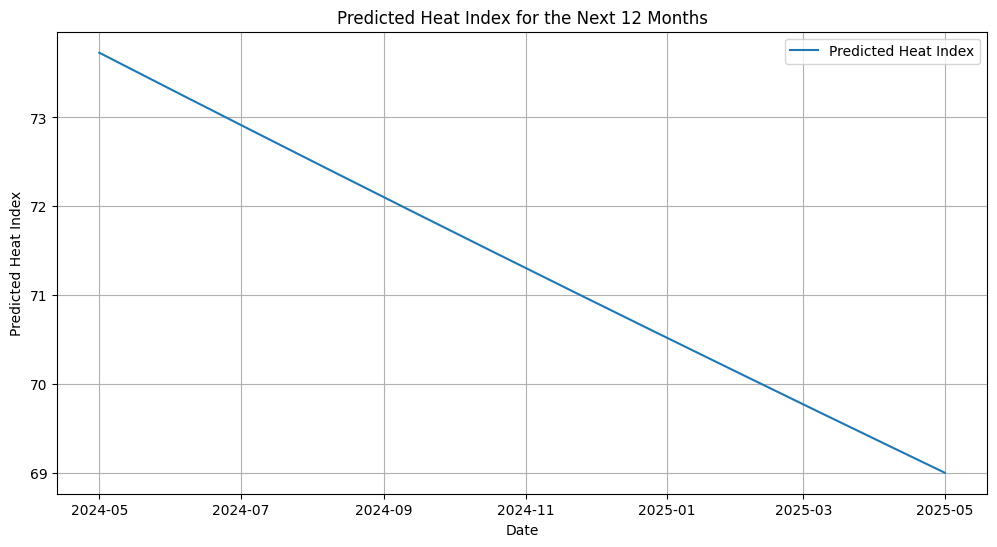

In [ ]:

# Generate the date range for the next 12 months
start_date = '2024-05-01'
end_date = '2025-05-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Make predictions using the ARIMA model
future_forecast = model.predict(start=start_date, end=end_date, typ='levels')

# Combine the date range and predictions into a DataFrame
predicted_data_2024 = pd.DataFrame({'Date': date_range, 'Predicted Heat Index': future_forecast})

predicted_data_2024.to_csv('predicted_hi_data_future.csv')
print(predicted_data_2024)



# Create a line plot of the Predicted Heat Index values
plt.figure(figsize=(12, 6))
plt.plot(predicted_data_2024['Date'], predicted_data_2024['Predicted Heat Index'], label='Predicted Heat Index')
plt.xlabel('Date')
plt.ylabel('Predicted Heat Index')
plt.title('Predicted Heat Index for the Next 12 Months')
plt.legend()
plt.grid()
plt.show()


**PAST 12 MONTH  PREDICTION**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                 Date  Predicted Heat Index
2023-05-02 2023-05-02             78.781888
2023-05-03 2023-05-03             78.767581
2023-05-04 2023-05-04             78.753277
2023-05-05 2023-05-05             78.738975
2023-05-06 2023-05-06             78.724676
...               ...                   ...
2024-04-27 2024-04-27             73.782333
2024-04-28 2024-04-28             73.768934
2024-04-29 2024-04-29             73.755537
2024-04-30 2024-04-30             73.742143
2024-05-01 2024-05-01             73.728752

[366 rows x 2 columns]


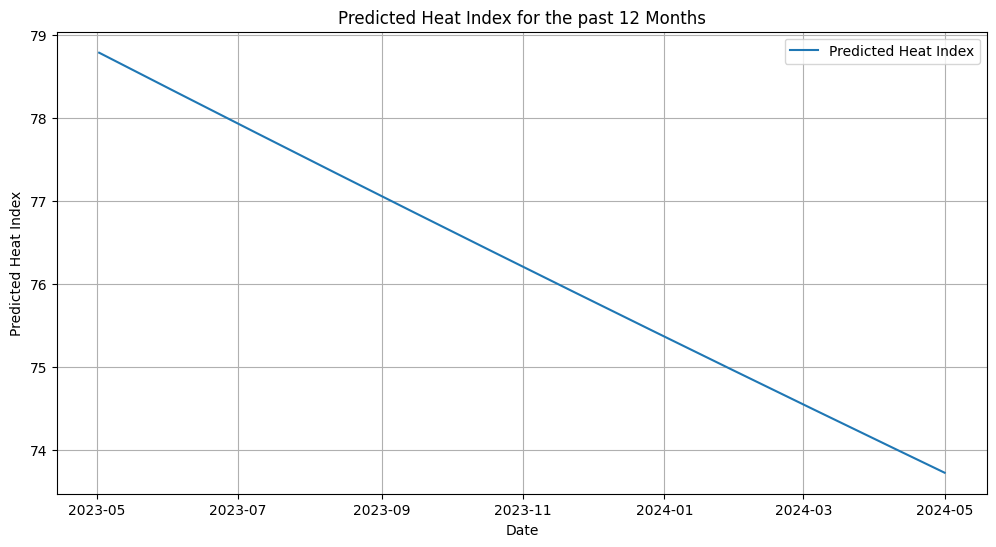

In [ ]:

# Generate the date range for the past 12 months
start_date = '2023-05-02'
end_date = '2024-05-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Make predictions using the ARIMA model
future_forecast = model.predict(start=start_date, end=end_date, typ='levels')

# Combine the date range and predictions into a DataFrame
predicted_data_2022 = pd.DataFrame({'Date': date_range, 'Predicted Heat Index': future_forecast})
print(predicted_data_2022)



# Create a line plot of the Predicted Heat Index values
plt.figure(figsize=(12, 6))
plt.plot(predicted_data_2022['Date'], predicted_data_2022['Predicted Heat Index'], label='Predicted Heat Index')
plt.xlabel('Date')
plt.ylabel('Predicted Heat Index')
plt.title('Predicted Heat Index for the past 12 Months')
plt.legend()
plt.grid()
plt.show()


**Export to CSV**

In [ ]:
# Export the predicted data for 2022 to a CSV file
predicted_data_2022.to_csv('predicted_hi_data_past.csv', index=True)

# Export the predicted data for 2024 to a CSV file
predicted_data_2024.to_csv('predicted_hi_data_future.csv', index=True)


**Compare future vs past**

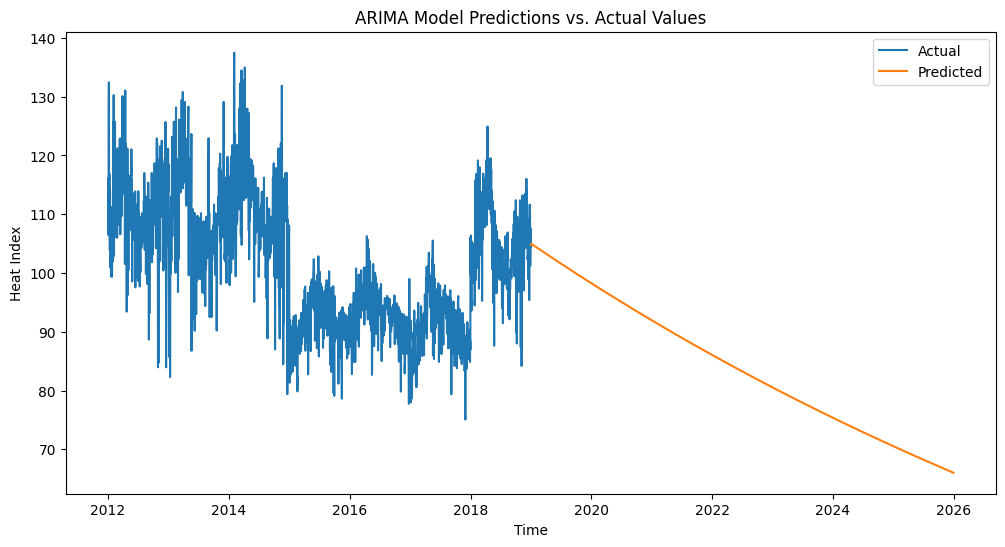

In [ ]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training')
plt.plot(data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('ARIMA Model Predictions vs. Actual Values')
plt.xlabel('Time')
plt.ylabel('Heat Index')
plt.legend()
plt.show()


In [ ]:
import pickle

# Assuming your trained model is named 'model'
with open('arima_model_hi.pkl', 'wb') as file:
    pickle.dump(model, file)
